In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

In [5]:
df_path = 'C:/Users/nile/Desktop/电子产品销售分析.csv'
df_u = pd.read_csv(df_path)

In [6]:
df_u

,Unnamed: 0,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,24.0,女,海南
1,1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,24.0,女,海南
2,2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,38.0,女,北京
3,3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,38.0,女,北京
4,4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18,32.0,女,广东
...,...,...,...,...,...,...,...,...,...,...,...,...
564164,2633516,2020-11-21 10:10:01 UTC,2388440981134693942,1515966223526602848,2.268105e+18,electronics.smartphone,oppo,138.87,1.515916e+18,21.0,男,上海
564165,2633517,2020-11-21 10:10:13 UTC,2388440981134693943,1515966223509089282,2.268105e+18,electronics.smartphone,apple,418.96,1.515916e+18,21.0,女,北京
564166,2633518,2020-11-21 10:10:30 UTC,2388440981134693944,1515966223509089917,2.268105e+18,appliances.personal.scales,vitek,12.48,1.515916e+18,19.0,女,上海
564167,2633519,2020-11-21 10:10:30 UTC,2388440981134693944,2273948184839454837,2.268105e+18,NaN,moulinex,41.64,1.515916e+18,19.0,女,上海


## 一、数据处理

In [4]:
del df_u['category_code']
df_u.fillna('no_brand',inplace = True)
df_u = df_u.drop_duplicates('order_id')
df_u['event_time'] = df_u['event_time'].str.replace('1970','2020')
df_u['event_time'] = pd.to_datetime(df_u['event_time']).dt.to_period('D')
df_u = df_u.set_index('event_time',drop = False)
df_u['month'] = df_u['event_time'].dt.month


![Image Name](https://cdn.kesci.com/upload/image/quze6mpn3b.JPG?imageView2/0/w/960/h/960)


In [5]:
df = df_u
user_record=df.groupby('user_id')['order_id'].count().sort_values(ascending=False)
df_b = df.loc[df['user_id'].isin(user_record[user_record<30].index)]
df_b['user_level']= 'B'
df_a=df.loc[~df['user_id'].isin(list(df_b['user_id']))]
df_a['user_level']='A'
df_ab = pd.concat([df_a,df_b])

#### 结论与建议：
* 用户的订单数分布差异极大，最大订单数为666，但是超过75%的用户订单数都在3以内
* 通过对数据分组，发现98.9%的用户订单数都在30以内；从数据的分布情况以及实际消费场景，我们按照30为界限对用户进行分类
* A类客户（总订单数>=30），B类客户(总订单数<30)
* A类客户均为高频稳定消费群体，且群体总量较小，所以本次分析的重点会聚焦 B 类客户

[Text(0, 0, '订单额'), Text(1, 0, '订单数')]

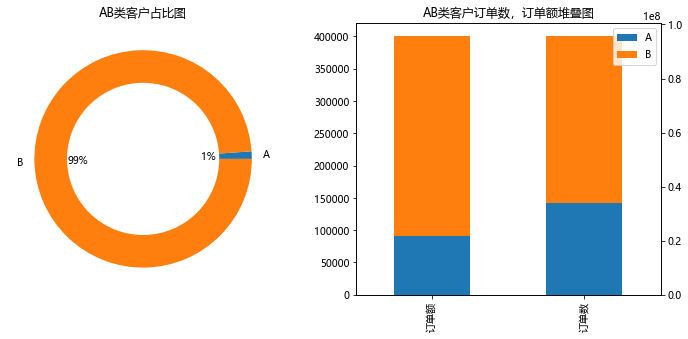

In [5]:
fig,axs = plt.subplots(1,2 ,figsize=(12,5))
df_ab.groupby('user_level')['user_id'].nunique().plot(kind='pie',title='AB类客户占比图',ax=axs[0],autopct='%.0f%%',ylabel='',wedgeprops={'width':0.3})
ax1 = pd.concat([pd.DataFrame({'A':[0]}),df_ab.groupby('user_level').agg({'order_id':pd.Series.count}).T],axis=0).plot(kind = 'bar',legend=False,ax=axs[1],stacked=True,xlabel='',title='AB类客户订单数，订单额堆叠图')
pd.concat([df_ab.groupby('user_level').agg({'price':np.sum}).T,pd.DataFrame({'A':[0]})],axis=0).plot(kind = 'bar',ax=ax1.twinx(),stacked=True,xlabel='').set_xticklabels(['订单额','订单数'])

* 通过对比发现：A类客户以1%的数量贡献了近20%的销售额，A类客户可能是异常数据，否者A类客应该户视作KA客户分析
* 下面的分析重点围绕B类客户进行分析，A类客户不做过多分析

In [6]:
df.head(1)

,Unnamed: 0,event_time,order_id,product_id,category_id,brand,price,user_id,age,sex,local,month
event_time,,,,,,,,,,,,
2020-04-24,0,2020-04-24,2294359932054536986,1515966223509089906,2.268105e+18,samsung,162.01,1.515916e+18,24.0,女,海南,4


## 二、消费人群分析&画像分析


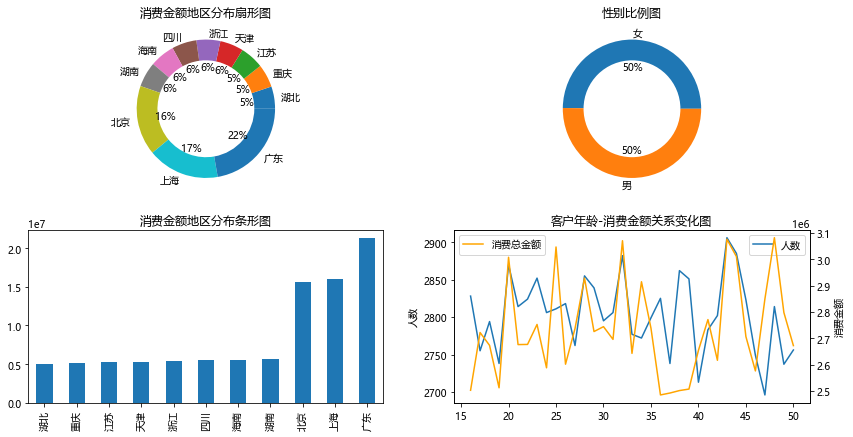

In [7]:
fig,axs = plt.subplots(2,2,figsize=(14,14))
df.groupby('local')['price'].sum().sort_values().plot(kind='bar',ax=axs[1,0],xlabel='',title='消费金额地区分布条形图')
df.groupby('local')['price'].sum().sort_values().plot(kind = 'pie',ylabel='',ax=axs[0,0],autopct='%.0f%%',wedgeprops={'width':0.3},title='消费金额地区分布扇形图')
df.groupby('sex')['user_id'].nunique().plot(kind='pie',title='性别比例图',ax=axs[0,1],ylabel='',autopct='%.0f%%',wedgeprops={'width':0.3})
ax1 = df.groupby('age')['user_id'].nunique().rename('人数').plot(title='客户年龄-消费金额关系变化图',ylabel='人数',ax=axs[1,1],xlabel='',legend=1)
df.groupby('age')['price'].sum().rename('消费总金额').plot(ax=ax1.twinx(),color='orange',figsize=(14,7),ylabel='消费金额',legend=True,xlabel='').legend(loc=2)

#### 结果与建议
* 1.北上广的消费能力远超其他地区，消费金额是其他地区的两倍以上，且占了总销售额一般以上，营销策略上可以重点向一线城市倾斜
* 2.对消费人群的年龄和性别分析发现，有异动数据，但没有明显的的特征

## 三、产品分析

<AxesSubplot:title={'center':'Top10品牌销售额占比Totll'}>

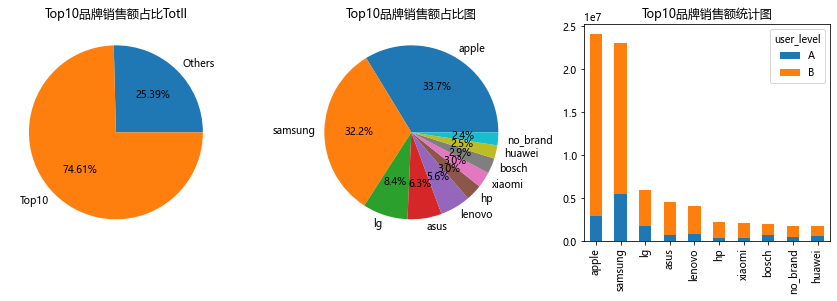

In [8]:
fig,axs = plt.subplots(1,3,figsize= (15,4))
df_ab.groupby(['brand','user_level'])['price'].sum().unstack().sort_values(by=['B'],ascending=False).head(10).plot(stacked=True,kind='bar',title='Top10品牌销售额统计图',ax=axs[2],xlabel='')
df.groupby('brand')['price'].sum().sort_values(ascending=False).head(10).plot(kind='pie',autopct='%.1f%%',ax=axs[1],ylabel='',title='Top10品牌销售额占比图')
top_sales=df.groupby('brand')['price'].sum().sort_values(ascending=False).head(10).sum()
pd.Series({'Others':df['price'].sum()-top_sales,'Top10':top_sales}).plot(kind='pie',title='Top10品牌销售额占比Totll',autopct='%.2f%%',ax=axs[0],ylabel='')


![Image Name](https://cdn.kesci.com/upload/image/quze86y3fu.jpg?imageView2/0/w/960/h/960)


#### 结果与建议
* 1.门店的销售额集中在前两大品牌，前两大品牌销售额占总销售额49%
* 2.对比2020年中国手机市场份额，可以发现门店的品牌销售占比与整体市场差异较大
* 3.在不是专卖店的前提下，可以尝试深度挖掘其他品牌的销售机会，会大大提高门店的销售额

## 四、销量分析

<AxesSubplot:title={'center':'销售额-月度统计'}>

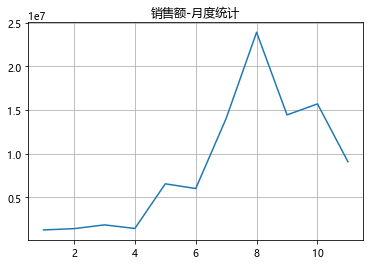

In [9]:
df_ab.groupby([df_ab['event_time'].dt.month])['price'].sum().plot(grid=True,title='销售额-月度统计',xlabel='')


![Image Name](https://cdn.kesci.com/upload/image/quze8o36uc.JPG?imageView2/0/w/960/h/960)


* 1. 销售额在4月到8月经历了快速增长，但是8月后快速下滑，累计下滑59%
* 2. 通过对比手机的整体市场的销量情况，门店出现较为明显的背离现象
* 3. 下面就原因进行分析挖掘，寻找解决方法

### 4.1、订单分析

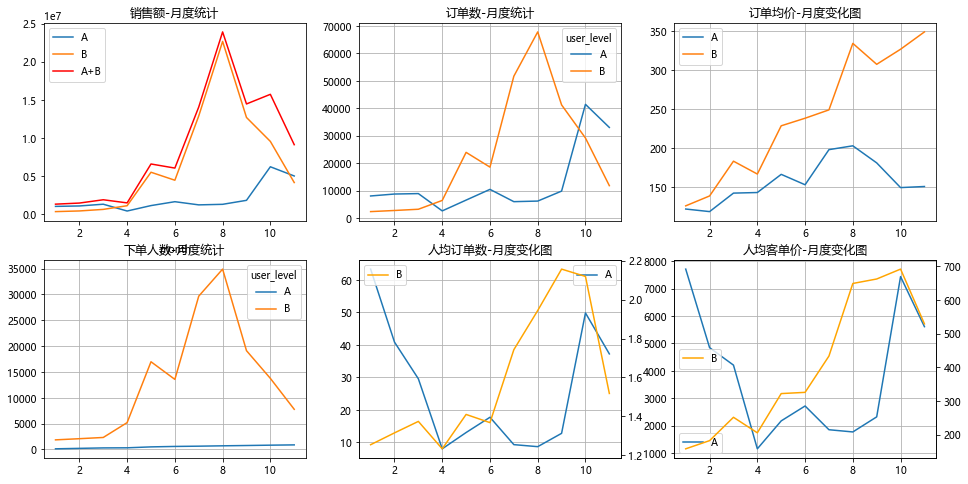

In [10]:
fig,axs = plt.subplots(2,3,figsize= (16,8))
df_ab.groupby(['month','user_level'])['price'].sum().unstack().plot(grid=True,title='销售额-月度统计',xlabel='',ax=axs[0,0])
df_ab.groupby('month')['price'].sum().rename('A+B').plot(ax=axs[0,0],color='r').legend(loc=2)
df_ab.groupby(['month','user_level'])['order_id'].count().unstack().plot(grid=True,title='订单数-月度统计',xlabel='',ax=axs[0,1])
(df_a.groupby('month')['price'].sum()/df_a.groupby('month')['order_id'].count()).rename('A').plot(xlabel='',ax=axs[0,2])
(df_b.groupby('month')['price'].sum()/df_b.groupby('month')['order_id'].count()).rename('B').plot(grid=True,title='订单均价-月度变化图',xlabel='',ax=axs[0,2]).legend(loc=2)
df_ab.groupby(['month','user_level']).user_id.nunique().unstack().plot(grid=True,title='下单人数-月度统计',xlabel='',ax=axs[1,0])
ax2 = (df_a.groupby('month')['order_id'].count()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[1,1],legend=1)
(df_b.groupby('month')['order_id'].count()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='人均订单数-月度变化图',xlabel='',ax=ax2.twinx(),color='orange').legend(loc=2)
ax1 = (df_a.groupby('month')['price'].sum()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[1,2],legend=1)
(df_b.groupby('month')['price'].sum()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='人均客单价-月度变化图',xlabel='',ax=ax1.twinx(),color='orange').legend(loc=6)

#### 结论与建议
* 1.下单人数,和订单量流失是造成销售额下滑的主要原因
* 2.B类客户的订单均价和人均客单价一直保持上升趋势
* 3.B类客户的人均订单数和客单件也在稳步上升,
* 4.从订单和人均数据可以发现，4-8月有明显的流量导入，8月后流量较少，同时会员的价值在不断释放
* 5.注意，这里11月份的销量截止到21号，这里不做过多解读

### 4.2、月度会员分析

In [11]:
#用户分层
def active_status(x):
    status = []
    for i in range(11):
        if x[i] == 0:
            if i == 0:
                status.append('unreg')
            else :
                status.append('unreg') if status[i-1] == 'unreg' else  status.append('unactive')            
        else:
            if i == 0:
                status.append('new')
            else:
                if status[i-1] == 'unreg':
                    status.append('new') 
                else:
                    status.append('return') if status[i-1]=='unactive' else status.append('active')
    return pd.Series(status,index = columns_month)

columns_month = df['month'].sort_values().astype('str').unique()
order_record = df.pivot_table(index = 'user_id',columns='month',values ='price',aggfunc='sum').fillna(0).applymap(lambda i: 1 if i>0 else 0)
order_record.columns = df['month'].sort_values().astype('str').unique()
user_active_status = order_record.apply(active_status,axis = 1)

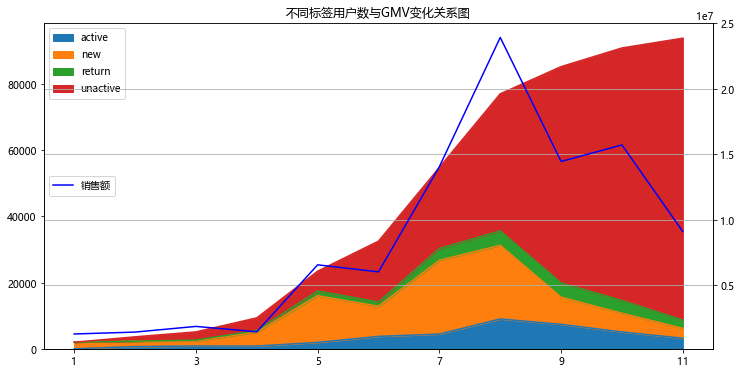

In [12]:
ax1= user_active_status.apply(lambda x: pd.value_counts(x)).drop('unreg').fillna(0).T.plot(kind='area',figsize=(12,6))
df_ab.groupby([df_ab['event_time'].dt.month])['price'].sum().rename('销售额').plot(ax=ax1.twinx(),grid=True,color='b',title='不同标签用户数与GMV变化关系图',xlabel='',use_index=False).legend(loc=6)

#### 结果与建议
* 1.4月到8月的销售额的增加，主要是因为新用户的持续导入
* 2.8月后新用户数急剧下滑，不活跃用户急剧增加，销售额随之大幅下滑
* 3.有部分会员成功转化为活跃会员，这也是在11月新用降至4月水平时，销售远高4月的重要原因
* 4.可以复盘8月后新用户降低的原因，同时从ROI的角度复盘4-8月运营策略，以及政策是否可以持续

### 4.3、复购率与订单分析(B类客户)

<AxesSubplot:title={'center':'复购率与购物次数关系-变化图'}>

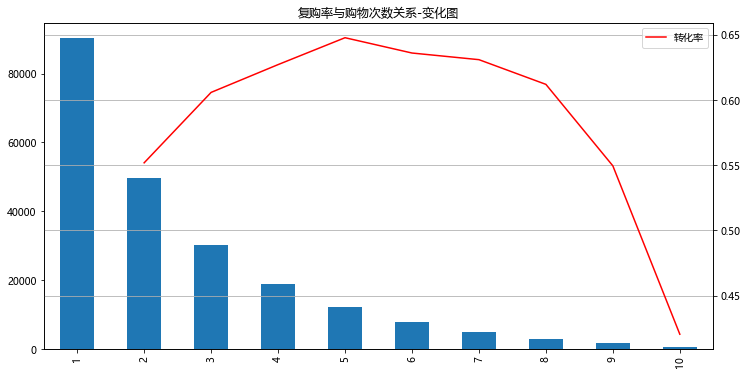

In [13]:
order_totll = df_b.groupby('user_id').agg({'order_id':pd.Series.count,'price':np.max}).groupby('order_id')['price'].count().head(10)
order_fq=[]
for i in range(10):
    a=order_totll.iloc[i:].sum()
    order_fq.append(a)
order_fq = pd.Series(order_fq,index=list(range(1,11)))
ax1 = order_fq.head(10).plot(kind='bar',figsize=(12,6),xlabel='')
(order_fq.pct_change(periods=1)+1).rename('转化率').plot(use_index=False,color='r',title='复购率与购物次数关系-变化图',grid=True,ax=ax1.twinx(),legend=1)

<AxesSubplot:title={'center':'B 类客户前10订单占比图'}>

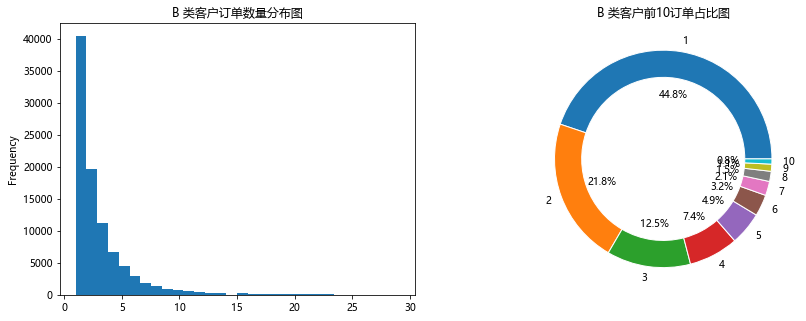

In [14]:
fig,axs = plt.subplots(1,2 ,figsize=(14,5))
df_b.groupby('user_id')['order_id'].count().plot(kind='hist',bins=30,ax=axs[0],title ='B 类客户订单数量分布图')
order_totll.plot(wedgeprops={'width':0.25,'edgecolor':'w'},ylabel='',kind='pie',autopct='%.1f%%',ax=axs[1],title ='B 类客户前10订单占比图')

#### 结果与建议
* 1.会员的二次复购率为55%，且随着复购次数的增加，转化率先升后降，在9次以后，出现大幅下滑
* 2.根据“数据魔方”的行业数据，电子产品的复购率在30%—40%之间，门店复购率相对较高，会员管理较为优秀

### 4.4、二次订单间隔分布分析(B类客户)

In [6]:
order_2b = df_b[['user_id','event_time','order_id']].reset_index(drop = True)
order_2b = order_2b.groupby(by=['user_id','event_time'],as_index=False)['order_id'].count()
order_2b = order_2b.pivot_table(index='user_id',columns='event_time',values='order_id').fillna(0)

In [7]:
def data_count(x): 
    fig =0
    for i in range(len(x)):
        if x.iloc[i] !=0:
            if fig!=1 :
                fig+=1 
                a=i
            else:
                a=i-a
                return a
second_order =order_2b.apply(data_count,axis=1) 

In [8]:
fig,axs = plt.subplots(1,2,figsize=(14,5))
second_order.plot(kind="box",title='二次下单间隔-箱线图（天）',ax=axs[0])
second_order.plot(kind="hist",title='二次下单间隔-直方图（天）',ax=axs[1],bins=60)

<AxesSubplot:title={'center':'二次下单间隔-直方图（天）'}, ylabel='Frequency'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei


<Figure size 1008x360 with 2 Axes>

#### 结果与建议
* 1.通过统计得出，约70%的会员的二次回购的行为发生在50天以内
* 2.会员的营销政策应该重点投放在购物后50天以内的时间段人群

## 五、会员RFM分析(B类客户)

In [9]:
b_r = df_b.groupby('user_id')['event_time'].min().map(lambda i : pd.to_datetime('2020-11-21').to_period('D')-i)
R = b_r.astype('str').map(lambda i: re.compile(r'\d*').findall(i)[1])
R.loc[b_r.astype('str').map(lambda i: re.compile(r'\d*').findall(i)[1])=='']=1
R = R.astype('int32')
F = df_b.groupby('user_id')['order_id'].count()
M = df_b.groupby('user_id')['price'].sum()

In [10]:
def RFM(x):
    r='1' if x[0]<= 30 else '0' # 最近购物天数在30天以内
    f='1' if x[1]>= 3 else '0'  # 累计购物次数大于2次（均值）
    m='1' if x[2]>=1257 else '0' # 累计消费金额大于1257（均值）
    return dic_rfm[r+f+m]
dic_rfm ={
    '111':'重要会员：倾斜更多资源，VIP服务，个性化服务，附加销售',
    '011':'重要唤回会员：DM营销，提供有用的资源，通过新的商品召唤回',
    '101':'重要深耕会员：交叉销售，制定会员忠诚度计划，推荐其他商品',
    '001':'重要挽留会员：重点联系或摆放，提高留存率',
    '110':'潜力会员：向上营销，销售价值更高的商品',
    '100':'新会员：提供免费试用，提高会员兴趣，创建品牌知名度',
    '010':'一般维持会员：积分制，分享宝贵资源，以折扣推荐热门商品',
    '000':'低价值会员：恢复会员兴趣，否者暂时放弃'}

In [11]:
b_rfm = pd.concat([R,F,M],axis=1).apply(RFM,axis=1)
B_RFM = pd.concat([b_rfm.map(lambda i: i.split('：')[0]).rename('会员类型'),b_rfm.map(lambda i: i.split('：')[-1]).rename('营销策略')],axis=1)

In [12]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
B_RFM.groupby('会员类型')['营销策略'].count().plot(kind='pie',title='B会员-类型占比',autopct='%.0f%%',ax=axs[1],wedgeprops={'width':0.3},ylabel='')
B_RFM.groupby('会员类型')['营销策略'].count().sort_values().plot(kind='barh',title='B会员-类型分布',xlabel='',ax=axs[0],grid=1)

<AxesSubplot:title={'center':'B会员-类型分布'}>

<Figure size 1152x432 with 2 Axes>

#### 结果与建议
* 1.门店可以根据会员RFM类型，进行不同的营销行为，以达到效率最大化
* 2.门店有较多的重要换回会员，潜在价值较高，可以重点跟踪

## 六、结论

* 1.门店4-8的销售额上升与8月后的销量下降，主要是应为新会员的变化
* 2.在经理4-8月的会员数暴增后，有一部分会员转化为了活跃会员，高价值会员，所以销售额并没有回到原点
* 3.与同期市场相比，门店销量有明显的背离，如果4-8不是活动引流导致的销量变化，需要马上复盘8月后的下跌问题
* 4.通过对门店的会员分析发现，门店的会员运营是高于行业平均，可以继续深耕保持
* 5.通过对会员的消费分析发现，约70%的二次购物发生在50天以内，营销可以侧重
* 6.通过对会员的分类标签化管理，可以更好的进行会员管理营销，提升会员价值


#### 备注
* 数据来之和鲸社区：https://www.heywhale.com/mw/project/5fc253f46571040030a04bd1/content
* 以上分析均为独立探索分析，默认数据真实

## 七、仪表板